In [ ]:
# Copyright 2022 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Pricing Optimization 


<table align="left">

  <td>
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/pricing_optimization/pricing-optimization.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/colab-logo-32px.png" alt="Colab logo"> Run in Colab
    </a>
  </td>
  <td>
    <a href="https://github.com/GoogleCloudPlatform/vertex-ai-samples/blob/main/notebooks/official/workbench/pricing_optimization/pricing-optimization.ipynb">
      <img src="https://cloud.google.com/ml-engine/images/github-logo-32px.png" alt="GitHub logo">
      View on GitHub
    </a>
  </td>
  <td>
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/vertex-ai-samples/main/notebooks/official/workbench/pricing_optimization/pricing-optimization.ipynb">
      <img src="https://lh3.googleusercontent.com/UiNooY4LUgW_oTvpsNhPpQzsstV5W8F7rYgxgGBD85cWJoLmrOzhVs_ksK_vgx40SHs7jCqkTkCk=e14-rj-sc0xffffff-h130-w32" alt="Vertex AI logo">
      Open in Vertex AI Workbench
    </a>
  </td>                                                                                               
</table>

## Table of contents
* [Overview](#section-1)
* [Dataset](#section-2)
* [Objective](#section-3)
* [Costs](#section-4)
* [Create a BigQuery dataset](#section-5)
* [Load the dataset from Cloud Storage](#section-6)
* [Data analysis](#section-7)
* [Preprocess the data for training](#section-8)
* [Train the model using BigQuery ML](#section-9)
* [Generate forecasts from the model](#section-10)
* [Interpret the results to choose the best price](#section-11)
* [Clean up](#section-12)

## Overview
<a name="section-1"></a>

This notebook demonstrates analysis of pricing optimization on [CDM Pricing Data](https://github.com/trifacta/trifacta-google-cloud/tree/main/design-pattern-pricing-optimization) and automating the workflow using Vertex AI Workbench managed notebooks.

*Note: This notebook file was developed to run in a [Vertex AI Workbench managed notebooks](https://console.cloud.google.com/vertex-ai/workbench/list/managed) instance using the Python (Local) kernel. Some components of this notebook may not work in other notebook environments.*

## Dataset
<a name="section-2"></a>

The dataset used in this notebook is a part of the [CDM Pricing dataset](https://github.com/trifacta/trifacta-google-cloud/blob/main/design-pattern-pricing-optimization/CDM_Pricing_large_table.csv), which consists of product sales information on specified dates.

## Objective
<a name="section-3"></a>

The objective of this notebook is to build a pricing optimization model using Vertex AI. The following steps have been followed:  

- Load the required dataset from a Cloud Storage bucket.
- Analyze the fields present in the dataset.
- Process the data to build a model.
- Build a BigQuery ML forecast model on the processed data.
- Get forecasted values from the BigQuery ML model.
- Interpret the forecasts to identify the best prices.
- Clean up.

## Costs
<a name="section-4"></a>

This tutorial uses the following billable components of Google Cloud:

- Vertex AI
- BigQuery
- Cloud Storage


Learn about [Vertex AI
pricing](https://cloud.google.com/vertex-ai/pricing), [BigQuery pricing](https://cloud.google.com/bigquery/pricing) and [Cloud Storage
pricing](https://cloud.google.com/storage/pricing), and use the [Pricing
Calculator](https://cloud.google.com/products/calculator/)
to generate a cost estimate based on your projected usage.


### Set up your local development environment

**If you are using Colab or Vertex AI Workbench Notebooks**, your environment already meets
all the requirements to run this notebook. You can skip this step.

**Otherwise**, make sure your environment meets this notebook's requirements.
You need the following:

* The Google Cloud SDK
* Git
* Python 3
* virtualenv
* Jupyter notebook running in a virtual environment with Python 3

The Google Cloud guide to [Setting up a Python development
environment](https://cloud.google.com/python/setup) and the [Jupyter
installation guide](https://jupyter.org/install) provide detailed instructions
for meeting these requirements. The following steps provide a condensed set of
instructions:

1. [Install and initialize the Cloud SDK.](https://cloud.google.com/sdk/docs/)

1. [Install Python 3.](https://cloud.google.com/python/setup#installing_python)

1. [Install
   virtualenv](https://cloud.google.com/python/setup#installing_and_using_virtualenv)
   and create a virtual environment that uses Python 3. Activate the virtual environment.

1. To install Jupyter, run `pip3 install jupyter` on the
command-line in a terminal shell.

1. To launch Jupyter, run `jupyter notebook` on the command-line in a terminal shell.

1. Open this notebook in the Jupyter Notebook Dashboard.

### Install additional packages


In [7]:
import os

# The Google Cloud Notebook product has specific requirements
IS_GOOGLE_CLOUD_NOTEBOOK = os.path.exists("/opt/deeplearning/metadata/env_version")

# Google Cloud Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_GOOGLE_CLOUD_NOTEBOOK:
    USER_FLAG = "--user"

In [10]:
! pip3 install {USER_FLAG} --upgrade pandas-gbq 'google-cloud-bigquery[bqstorage,pandas]' seaborn fsspec gcsfs


     |████████████████████████████████| 1.2 MB 10.9 MB/s eta 0:00:01
     |████████████████████████████████| 264 kB 70.1 MB/s eta 0:00:01
     |████████████████████████████████| 114 kB 65.6 MB/s eta 0:00:01
     |████████████████████████████████| 158 kB 54.6 MB/s eta 0:00:01
You should consider upgrading via the '/usr/local/bin/python3 -m pip install --upgrade pip' command.


### Restart the kernel

After you install the additional packages, you need to restart the notebook kernel so it can find the packages.

In [7]:
# Automatically restart kernel after installs
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

## Before you begin

### Set up your Google Cloud project

**The following steps are required, regardless of your notebook environment.**

1. [Select or create a Google Cloud project](https://console.cloud.google.com/cloud-resource-manager). When you first create an account, you get a $300 free credit towards your compute/storage costs.

1. [Make sure that billing is enabled for your project](https://cloud.google.com/billing/docs/how-to/modify-project).

1. [Enable the Vertex AI, Cloud Storage, and Compute Engine APIs](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com,compute_component,storage-component.googleapis.com). 

1. [Configure your Google Cloud project for Vertex Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/configure-project).

1. If you are running this notebook locally, you will need to install the [Cloud SDK](https://cloud.google.com/sdk).

1. Enter your project ID in the cell below. Then run the cell to make sure the
Cloud SDK uses the right project for all the commands in this notebook.

**Note**: Jupyter runs lines prefixed with `!` as shell commands, and it interpolates Python variables prefixed with `$` into these commands.

### Set your project ID

**If you don't know your project ID**, you may be able to get your project ID using `gcloud`.

In [11]:
import os

PROJECT_ID = ""

# Get your Google Cloud project ID from gcloud
if not os.getenv("IS_TESTING"):
    shell_output = !gcloud config list --format 'value(core.project)' 2>/dev/null
    PROJECT_ID = shell_output[0]
    print("Project ID: ", PROJECT_ID)

Project ID:  vertex-ai-dev


Otherwise, set your project ID here.

In [ ]:
if PROJECT_ID == "" or PROJECT_ID is None:
    PROJECT_ID = "[your-project-id]"  # @param {type:"string"}

#### UUID

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a uuid for each instance session, and append it onto the name of resources you create in this tutorial.


In [12]:
import random
import string


# Generate a uuid of a specifed length(default=8)
def generate_uuid(length: int = 8) -> str:
    return "".join(random.choices(string.ascii_lowercase + string.digits, k=length))


UUID = generate_uuid()

### Authenticate your Google Cloud account

**If you are using Vertex AI Workbench Notebooks**, your environment is already
authenticated. Skip this step.

**If you are using Colab**, run the cell below and follow the instructions
when prompted to authenticate your account via oAuth.

**Otherwise**, follow these steps:

1. In the Cloud Console, go to the [**Create service account key**
   page](https://console.cloud.google.com/apis/credentials/serviceaccountkey).

2. Click **Create service account**.

3. In the **Service account name** field, enter a name, and
   click **Create**.

4. In the **Grant this service account access to project** section, click the **Role** drop-down list. Type "Vertex AI"
into the filter box, and select
   **Vertex AI Administrator**. Type "Storage Object Admin" into the filter box, and select **Storage Object Admin**.

5. Click *Create*. A JSON file that contains your key downloads to your
local environment.

6. Enter the path to your service account key as the
`GOOGLE_APPLICATION_CREDENTIALS` variable in the cell below and run the cell.

In [ ]:
# If you are running this notebook in Colab, run this cell and follow the
# instructions to authenticate your GCP account. This provides access to your
# Cloud Storage bucket and lets you submit training jobs and prediction
# requests.

import os
import sys

# If on Vertex AI Workbench, then don't execute this code
IS_COLAB = "google.colab" in sys.modules
if not os.path.exists("/opt/deeplearning/metadata/env_version") and not os.getenv(
    "DL_ANACONDA_HOME"
):
    if "google.colab" in sys.modules:
        from google.colab import auth as google_auth

        google_auth.authenticate_user()

    # If you are running this notebook locally, replace the string below with the
    # path to your service account key and run this cell to authenticate your GCP
    # account.
    elif not os.getenv("IS_TESTING"):
        %env GOOGLE_APPLICATION_CREDENTIALS ''

### Import the required libraries and define constants


In [13]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from google.cloud import bigquery
from google.cloud.bigquery import Client

In [32]:
DATASET = "pricing_optimization" + "_" + UUID  # set the BigQuery dataset-id
TRAINING_DATA_TABLE = (
    "training_data_table"  # set the BigQuery table-id to store the training data
)

## Create a BigQuery dataset
<a name="section-5"></a>


If you are using ***Vertex AI Workbench managed notebooks instance***, every cell which starts with "#@bigquery" will be a SQL Query. If you are using Vertex AI Workbench user managed notebooks instance or Colab it will be a markdown cell.

#@bigquery
-- create a dataset in BigQuery

CREATE SCHEMA [your-dataset-id]
OPTIONS(
  location="us"
  )

In [28]:
# Construct a BigQuery client object.
client = Client(project=PROJECT_ID)

In [47]:
query = """
CREATE SCHEMA {DATASET}
OPTIONS(
  location="us"
  )
""".format(
    DATASET=DATASET
)
query_job = client.query(query)
print(query_job.result())

## Load the dataset from Cloud Storage
<a name="section-6"></a>


In [15]:
DATA_LOCATION = "gs://cloud-samples-data/ai-platform-unified/datasets/tabular/cdm_pricing_large_table.csv"
df = pd.read_csv(DATA_LOCATION)
print(df.shape)
df.head()

(60768, 25)


,Fiscal_Date,Product_ID,Client_ID,Customer_Hierarchy,Division,Market,Channel,Customer_code,Customer_Long_Description,Key_Account_Manager,...,Cash_Discounts_and_other_Sales_Deductions,Net_Sales,Variable_Production_Costs_STD,Fixed_Production_Costs_STD,Other_Cost_of_Sales,Standard_Gross_Margin,Transportation_STD,Warehouse_STD,Gross_Margin_After_Logistics,List_Price_Converged
0,2013-06-18 00:00:00,SKU 187,4126,Utilities,Division 747,France,Internet,33424,Old Bond Spirits,929708,...,0,70.490752,-23.715342,-2.941762,0.0,43.833648,-3.597036,-1.143244,39.093368,3.14
1,2013-01-27 00:00:00,SKU 187,4126,Utilities,Division 747,France,Distributor,33424,Old Bond Spirits,929708,...,0,70.490752,-23.715342,-2.941762,0.0,43.833648,-3.597036,-1.143244,39.093368,3.14
2,2013-08-23 00:00:00,SKU 187,4126,Utilities,Division 747,France,Internet,33424,Old Bond Spirits,929708,...,0,70.490752,-23.715342,-2.941762,0.0,43.833648,-3.597036,-1.143244,39.093368,3.14
3,2013-11-04 00:00:00,SKU 187,4126,Utilities,Division 747,France,Internet,33424,Not provided,929708,...,0,70.490752,-23.715342,-2.941762,0.0,43.833648,-3.597036,-1.143244,39.093368,3.14
4,2012-05-27 00:00:00,SKU 187,4126,Utilities,Division 747,France,Internet,33424,Not provided,929708,...,0,70.490752,-23.715342,-2.941762,0.0,43.833648,-3.597036,-1.143244,39.093368,3.14


You will build a forecast model on this data and thus determine the best price for a product. For this type of model, you will not be using many fields: only the sales and price related ones. For the current execrcise, focus on the following fields:

- `Product_ID`
- `Customer_Hierarchy`
- `Fiscal_Date`
- `List_Price_Converged`
- `Invoiced_quantity_in_Pieces`
- `Net_Sales`

## Data Analysis
<a name="section-7"></a>

First, explore the data and distributions.

Select the required columns from the dataframe.

In [16]:
id_col = "Product_ID"
date_col = "Fiscal_Date"
categ_cols = ["Customer_Hierarchy"]
num_cols = ["List_Price_Converged", "Invoiced_quantity_in_Pieces", "Net_Sales"]

df = df[[id_col, date_col] + categ_cols + num_cols].copy()
df.head()

,Product_ID,Fiscal_Date,Customer_Hierarchy,List_Price_Converged,Invoiced_quantity_in_Pieces,Net_Sales
0,SKU 187,2013-06-18 00:00:00,Utilities,3.14,128.6592,70.490752
1,SKU 187,2013-01-27 00:00:00,Utilities,3.14,128.6592,70.490752
2,SKU 187,2013-08-23 00:00:00,Utilities,3.14,128.6592,70.490752
3,SKU 187,2013-11-04 00:00:00,Utilities,3.14,128.6592,70.490752
4,SKU 187,2012-05-27 00:00:00,Utilities,3.14,128.6592,70.490752


Check the column types and null values in the dataframe.

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60768 entries, 0 to 60767
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Product_ID                   60768 non-null  object 
 1   Fiscal_Date                  60768 non-null  object 
 2   Customer_Hierarchy           60768 non-null  object 
 3   List_Price_Converged         60768 non-null  float64
 4   Invoiced_quantity_in_Pieces  60768 non-null  float64
 5   Net_Sales                    60768 non-null  float64
dtypes: float64(3), object(3)
memory usage: 2.8+ MB


This data description reveals that there are no null values in the data. Also, the field `Fiscal_Date` which is a date field is loaded as an object type. 

Change the type of the date field to datetime.

In [18]:
df["Fiscal_Date"] = pd.to_datetime(df["Fiscal_Date"], infer_datetime_format=True)

Plot the distributions for the categorical fields.

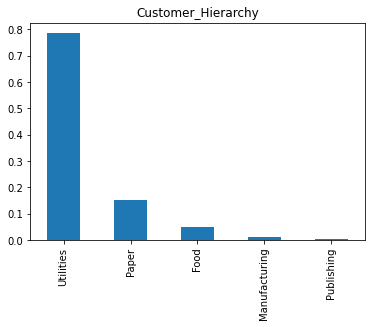

In [19]:
for i in categ_cols:
    df[i].value_counts(normalize=True).plot(kind="bar")
    plt.title(i)
    plt.show()

Plot the distributions for the numerical fields.

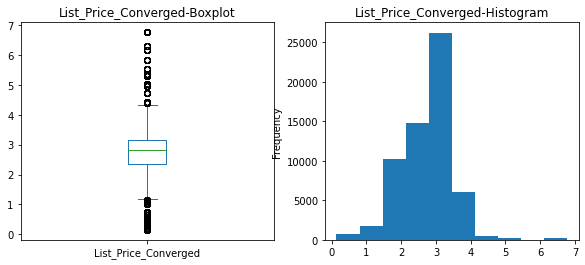

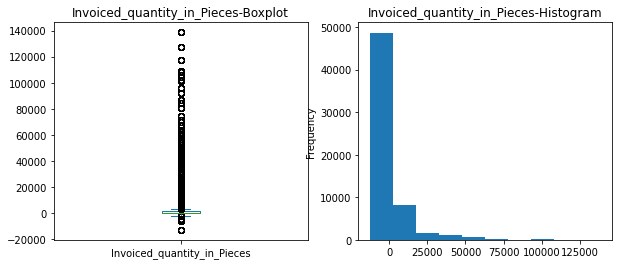

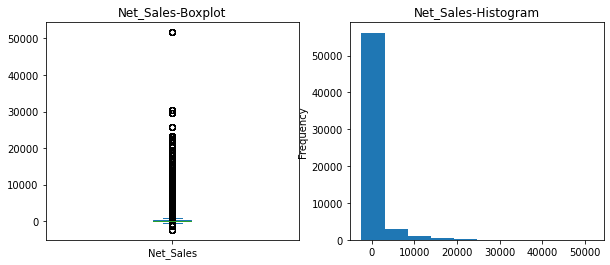

In [20]:
for i in num_cols:
    _, ax = plt.subplots(1, 2, figsize=(10, 4))
    df[i].plot(kind="box", ax=ax[0])
    df[i].plot(kind="hist", ax=ax[1])
    ax[0].set_title(i + "-Boxplot")
    ax[1].set_title(i + "-Histogram")
    plt.show()

Check the maximum date and minimum date in Fiscal_Date column.

In [21]:
print(df["Fiscal_Date"].max())
print(df["Fiscal_Date"].min())

2013-12-31 00:00:00
2012-01-01 00:00:00


Check the product distribution across each category.

In [22]:
grp_cols = ["Customer_Hierarchy", "Product_ID"]
grp_df = df[grp_cols].groupby(by=grp_cols).count().reset_index()
grp_df.groupby("Customer_Hierarchy").nunique()

,Product_ID
Customer_Hierarchy,
Food,64
Manufacturing,22
Paper,116
Publishing,10
Utilities,102


Check the percentage changes in the orders based on the percentage changes in the price.

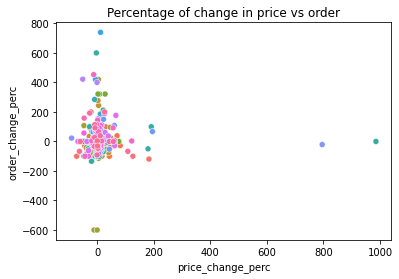

In [23]:
# aggregate the data
df_aggr = (
    df.groupby(["Product_ID", "List_Price_Converged"])
    .agg({"Fiscal_Date": min, "Invoiced_quantity_in_Pieces": sum, "Net_Sales": sum})
    .reset_index()
)
# rename the aggregated columns
df_aggr.rename(
    columns={
        "Fiscal_Date": "First_price_date",
        "Invoiced_quantity_in_Pieces": "Total_ordered_pieces",
        "Net_Sales": "Total_net_sales",
    },
    inplace=True,
)

# sort values chronologically
df_aggr.sort_values(by=["Product_ID", "First_price_date"], inplace=True)
df_aggr.reset_index(drop=True, inplace=True)

# add columns for previous values
df_aggr["Previous_List"] = df_aggr.groupby(["Product_ID"])[
    "List_Price_Converged"
].shift()
df_aggr["Previous_Total_ordered_pieces"] = df_aggr.groupby(["Product_ID"])[
    "Total_ordered_pieces"
].shift()

# average price change across sku's
df_aggr["price_change_perc"] = (
    (df_aggr["List_Price_Converged"] - df_aggr["Previous_List"])
    / df_aggr["Previous_List"].fillna(0)
    * 100
)
df_aggr["order_change_perc"] = (
    (df_aggr["Total_ordered_pieces"] - df_aggr["Previous_Total_ordered_pieces"])
    / df_aggr["Previous_Total_ordered_pieces"].fillna(0)
    * 100
)

# plot a scatterplot to visualize the changes
sns.scatterplot(
    x="price_change_perc",
    y="order_change_perc",
    data=df_aggr,
    hue="Product_ID",
    legend=False,
)
plt.title("Percentage of change in price vs order")
plt.show()

For most of the products, the percentage change in orders are high where the percentage changes in the prices are low. This suggests that too much change in the prices can affect the number of orders. 

**Note**: There seem to be some outliers in the data as percentage changes greater than 800 are found. In the current exercise, do not take any manual measures to deal with outliers as you will create a BigQuery ML timeseries model that already deals with outliers.

## Preprocess the data for training
<a name="section-8"></a>

Check which `Product_ID`'s  have the maximum orders.

In [24]:
df_orders = df.groupby(["Product_ID", "Customer_Hierarchy"], as_index=False)[
    "Invoiced_quantity_in_Pieces"
].sum()
df_orders.loc[
    df_orders.groupby("Customer_Hierarchy")["Invoiced_quantity_in_Pieces"].idxmax()
]

,Product_ID,Customer_Hierarchy,Invoiced_quantity_in_Pieces
249,SKU 62,Food,1.034613e+07
102,SKU 17,Manufacturing,3.553495e+06
13,SKU 107,Paper,2.960422e+07
286,SKU 8,Publishing,1.264818e+04
67,SKU 140,Utilities,6.308081e+06


From the above result, you can infer the following:

- Under the **Food** category, **SKU 62** has the maximum orders.
- Under the **Manufacturing** category, **SKU 17** has the maximum orders.
- Under the **Paper** category, **SKU 107** has the maximum orders.
- Under the **Publishing** category, **SKU 8** has the maximum orders.
- Under the **Utilities** category, **SKU 140** has the maximum orders.

Given that there are too many ids and only a few records for most of them, consider only the above `Product_ID`s for which there are a maximum number of orders. 

**Note**: The `Invoiced_quantity_in_Pieces` field seems to be a *float* type rather than an *int* type as it should be. This could be because the data itself might be averaged in the first place.

Check the various prices available for these `Product_ID`s.

In [25]:
df_type_food = df[(df["Product_ID"] == "SKU 62") & (df["Customer_Hierarchy"] == "Food")]
print("Food :")
print(df_type_food["List_Price_Converged"].value_counts())
df_type_manuf = df[
    (df["Product_ID"] == "SKU 17") & (df["Customer_Hierarchy"] == "Manufacturing")
]
print("Manufacturing :")
print(df_type_manuf["List_Price_Converged"].value_counts())
df_type_paper = df[
    (df["Product_ID"] == "SKU 107") & (df["Customer_Hierarchy"] == "Paper")
]
print("Paper :")
print(df_type_paper["List_Price_Converged"].value_counts())
df_type_pub = df[
    (df["Product_ID"] == "SKU 8") & (df["Customer_Hierarchy"] == "Publishing")
]
print("Publishing :")
print(df_type_pub["List_Price_Converged"].value_counts())
df_type_util = df[
    (df["Product_ID"] == "SKU 140") & (df["Customer_Hierarchy"] == "Utilities")
]
print("Utilities :")
print(df_type_util["List_Price_Converged"].value_counts())

Food :
6.77    18
3.05    18
4.23    18
2.11    18
1.89    18
1.84    18
Name: List_Price_Converged, dtype: int64
Manufacturing :
2.62    18
2.88    18
Name: List_Price_Converged, dtype: int64
Paper :
2.77    36
2.83    18
3.25    18
2.74    18
2.80    18
2.84    18
2.33    18
2.88    18
2.87    18
2.37    18
2.76    18
2.59    18
3.08    18
2.92    18
2.94    18
3.16    18
2.60    18
2.75    18
3.85    18
3.21    18
4.73    18
3.05    18
3.14    18
2.98    18
3.48    18
3.44    18
3.39    18
4.44    18
3.09    18
3.11    18
3.60    18
2.79    18
3.58    18
2.49    18
1.94    18
2.05    18
2.08    18
3.76    18
2.64    18
Name: List_Price_Converged, dtype: int64
Publishing :
1.58    18
Name: List_Price_Converged, dtype: int64
Utilities :
1.95    1116
1.92     954
2.09     810
Name: List_Price_Converged, dtype: int64


In the publishing category, `Product_ID` `SKU 8` and `SKU 17` are less than or equal to two different prices in the entire data and so you will exclude them and consider the rest for building the forecast model. The idea here is to train a forecast model on the timeseries data for products with different prices.

Join the data for all the `Product_ID`s into one dataframe and remove duplicate records.

In [26]:
df_final = pd.concat([df_type_food, df_type_paper, df_type_util])
df_final = (
    df_final[
        [
            "Product_ID",
            "Fiscal_Date",
            "Customer_Hierarchy",
            "List_Price_Converged",
            "Invoiced_quantity_in_Pieces",
        ]
    ]
    .drop_duplicates()
    .reset_index(drop=True)
)
df_final.head()

,Product_ID,Fiscal_Date,Customer_Hierarchy,List_Price_Converged,Invoiced_quantity_in_Pieces
0,SKU 62,2012-03-22,Food,6.77,101888.136
1,SKU 62,2013-10-29,Food,6.77,101888.136
2,SKU 62,2012-10-09,Food,6.77,101888.136
3,SKU 62,2012-07-06,Food,6.77,101888.136
4,SKU 62,2012-04-08,Food,6.77,101888.136


Save the data to a BigQuery table.

In [48]:
bq_client = bigquery.Client(project=PROJECT_ID)

job_config = bigquery.LoadJobConfig(
    # Specify a (partial) schema. All columns are always written to the
    # table. The schema is used to assist in data type definitions.
    schema=[
        bigquery.SchemaField("Product_ID", bigquery.enums.SqlTypeNames.STRING),
        bigquery.SchemaField("Fiscal_Date", bigquery.enums.SqlTypeNames.DATE),
        bigquery.SchemaField("List_Price_Converged", bigquery.enums.SqlTypeNames.FLOAT),
        bigquery.SchemaField(
            "Invoiced_quantity_in_Pieces", bigquery.enums.SqlTypeNames.FLOAT
        ),
    ],
    # Optionally, set the write disposition. BigQuery appends loaded rows
    # to an existing table by default, but with WRITE_TRUNCATE write
    # disposition it replaces the table with the loaded data.
    write_disposition="WRITE_TRUNCATE",
)

# save the dataframe to a table in the created dataset
job = bq_client.load_table_from_dataframe(
    df_final,
    "{}.{}.{}".format(PROJECT_ID, DATASET, TRAINING_DATA_TABLE),
    job_config=job_config,
)  # Make an API request.
job.result()  # Wait for the job to complete.

LoadJob<project=vertex-ai-dev, location=US, id=6d0cba0d-ed51-402d-8f16-d6632b512a59>

# Train the model using BigQuery ML
<a name="section-9"></a>

Train an [Arima-Plus](https://cloud.google.com/bigquery-ml/docs/reference/standard-sql/bigqueryml-syntax-create-time-series) model on the data using BigQuery ML.

#@bigquery
create or replace model [your-dataset-id].bqml_arima
options
 (model_type = 'ARIMA_PLUS',
  time_series_timestamp_col = 'Fiscal_Date',
  time_series_data_col = 'Invoiced_quantity_in_Pieces',
  time_series_id_col = 'ID'
 ) as
select
 Fiscal_Date,
 Concat(Product_ID,"_" ,Cast(List_Price_Converged as string)) as ID,
 Invoiced_quantity_in_Pieces
from
 [your-dataset-id].TRAINING_DATA


In [39]:
query = """
create or replace model `{PROJECT_ID}.{DATASET}.bqml_arima`
options
 (model_type = 'ARIMA_PLUS',
  time_series_timestamp_col = 'Fiscal_Date',
  time_series_data_col = 'Invoiced_quantity_in_Pieces',
  time_series_id_col = 'ID'
 ) as
select
 Fiscal_Date,
 Concat(Product_ID,"_" ,Cast(List_Price_Converged as string)) as ID,
 Invoiced_quantity_in_Pieces
from
 `{DATASET}.{TRAINING_DATA_TABLE}`""".format(
    PROJECT_ID=PROJECT_ID, DATASET=DATASET, TRAINING_DATA_TABLE=TRAINING_DATA_TABLE
)
query_job = client.query(query)
print(query_job.result())

## Generate forecasts from the model
<a name="section-10"></a>

Predict the sales for the next 30 days for each id and save to a dataframe.

In [40]:
query = '''
DECLARE HORIZON STRING DEFAULT "30"; #number of values to forecast
DECLARE CONFIDENCE_LEVEL STRING DEFAULT "0.90"; ## required confidence level

EXECUTE IMMEDIATE format("""
    SELECT
      *
    FROM 
      ML.FORECAST(MODEL {DATASET}.bqml_arima, 
                  STRUCT(%s AS horizon, 
                         %s AS confidence_level)
                 )
    """,HORIZON,CONFIDENCE_LEVEL)'''.format(
    DATASET=DATASET
)
job = client.query(query)
dfforecast = job.to_dataframe()
dfforecast.head()

,ID,forecast_timestamp,forecast_value,standard_error,confidence_level,prediction_interval_lower_bound,prediction_interval_upper_bound,confidence_interval_lower_bound,confidence_interval_upper_bound
0,SKU 107_1.94,2013-11-13 00:00:00+00:00,39401.88,0.0,0.9,39401.88,39401.88,39401.88,39401.88
1,SKU 107_1.94,2013-12-18 00:00:00+00:00,39401.88,0.0,0.9,39401.88,39401.88,39401.88,39401.88
2,SKU 107_1.94,2014-01-22 00:00:00+00:00,39401.88,0.0,0.9,39401.88,39401.88,39401.88,39401.88
3,SKU 107_1.94,2014-02-26 00:00:00+00:00,39401.88,0.0,0.9,39401.88,39401.88,39401.88,39401.88
4,SKU 107_1.94,2014-04-02 00:00:00+00:00,39401.88,0.0,0.9,39401.88,39401.88,39401.88,39401.88


## Interpret the results to choose the best price
<a name="section-11"></a>

Calculate average forecast values for the forecast duration.

In [41]:
dfforecast_avg = (
    dfforecast[["ID", "forecast_value"]].groupby("ID", as_index=False).mean()
)

Extract the ID and Price fields from the ID field.

In [42]:
dfforecast_avg["Product_ID"] = dfforecast_avg["ID"].apply(lambda x: x.split("_")[0])
dfforecast_avg["Price"] = dfforecast_avg["ID"].apply(lambda x: x.split("_")[1])

Plot the average forecasted sales vs. the price of the product.

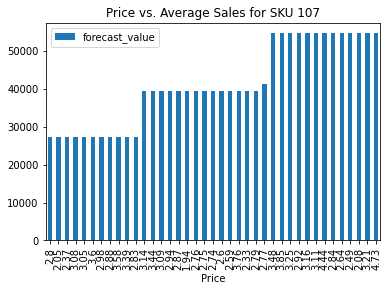

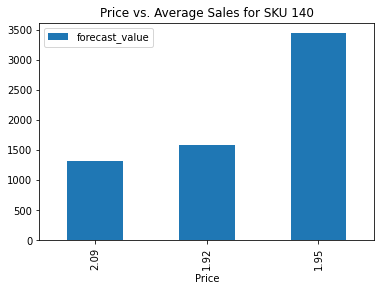

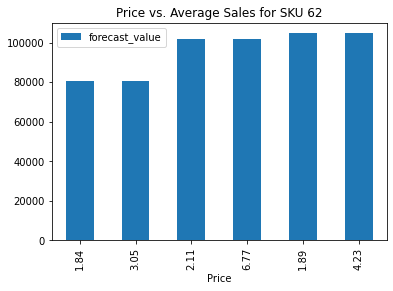

In [43]:
for i in dfforecast_avg["Product_ID"].unique():
    dfforecast_avg[dfforecast_avg["Product_ID"] == i].set_index("Price").sort_values(
        "forecast_value"
    ).plot(kind="bar")
    plt.title("Price vs. Average Sales for " + i)
    plt.show()

Based on the plots for price vs. the average forecasted orders, it can be said that to use the maximum orders, each of the considered `Product_ID`s can follow the below prices:

- SKU 107's price range can be from 4.44 - 4.73 units
- SKU 140's price can be 1.95 units
- SKU 62's price can be 4.23 units


## Clean Up
<a name="section-12"></a>

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial. The following code deletes the entire dataset.

In [44]:
# Set dataset_id to the ID of the dataset to fetch.
dataset_id = "{PROJECT_ID}.{DATASET}".format(PROJECT_ID=PROJECT_ID, DATASET=DATASET)

# Use the delete_contents parameter to delete a dataset and its contents.
# Use the not_found_ok parameter to not receive an error if the dataset has already been deleted.
client.delete_dataset(
    dataset_id, delete_contents=True, not_found_ok=True
)  # Make an API request.

print("Deleted dataset '{}'.".format(dataset_id))

Deleted dataset 'vertex-ai-dev.pricing_optimization_lgmxa22b'.
